In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import polars as pl
import pandas as pd

In [2]:
df = pl.read_csv("hosts.csv", encoding="utf8-lossy", ignore_errors=True, null_values=["NA", ""], infer_schema_length=0)

filtered_rat = df.filter(pl.col("hOrder") == "RODENTIA")

df2 = pl.read_csv("associations.csv", encoding="utf8-lossy", ignore_errors=True, null_values=["NA", ""], infer_schema_length=0)




In [3]:


filtered_rat_list = filtered_rat["hHostNameFinal"].to_list()
df2_rat = df2.filter(pl.col("hHostNameFinal").is_in(filtered_rat_list))

filtered_df2_rat = df2_rat.select(["hHostNameFinal", "vVirusNameCorrected", "DetectionQuality"])



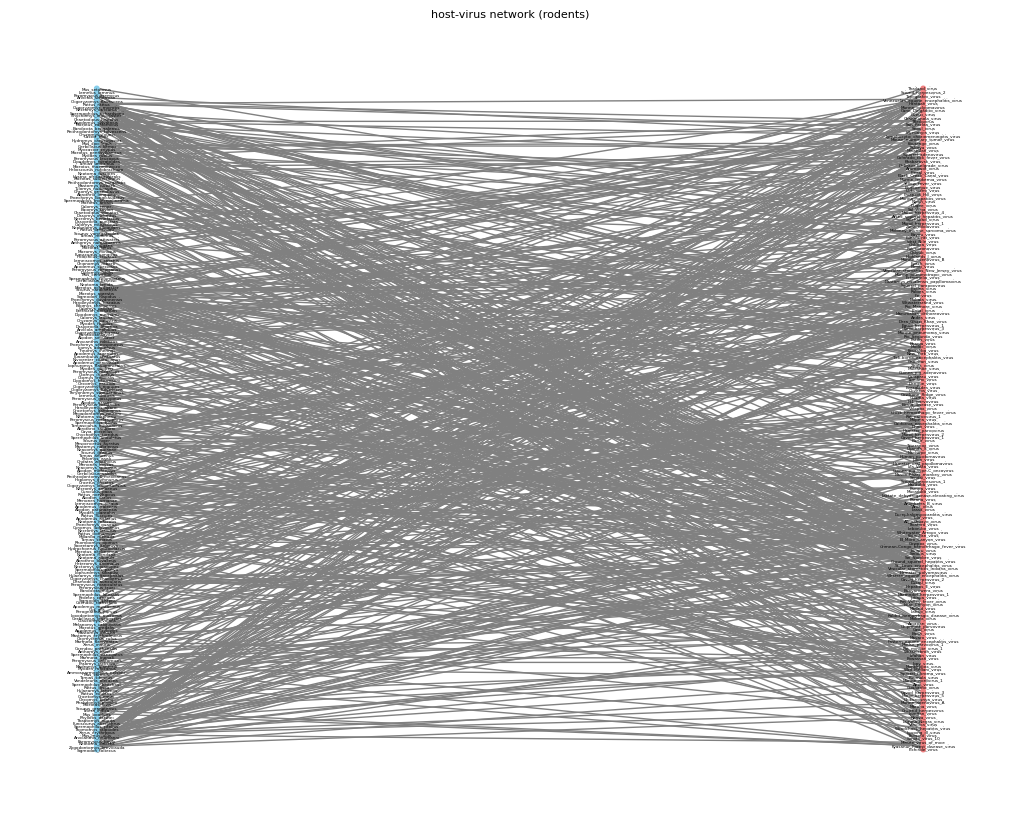

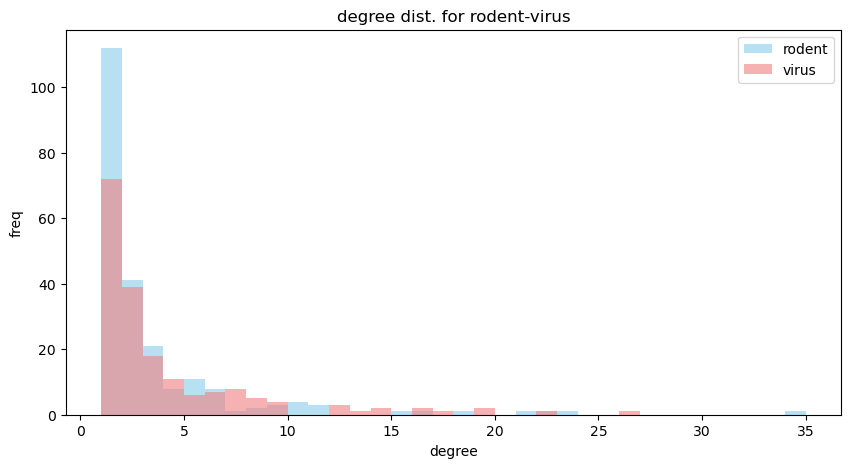

top rodents by degree:
Mus_musculus: 34
Rattus_rattus: 23
Sigmodon_hispidus: 22
Rattus_norvegicus: 21
top viruses by degree:
Andes_virus: 26
St._Louis_encephalitis_virus: 22
Whitewater_Arroyo_virus: 19
Colorado_tick_fever_virus: 19


In [4]:
#rodents

G_rat = nx.Graph()
G_rat.add_nodes_from(df2_rat["hHostNameFinal"], bipartite=0) 
G_rat.add_nodes_from(df2_rat["vVirusNameCorrected"], bipartite=1)
edge_list_rat = df2_rat.select(["hHostNameFinal", "vVirusNameCorrected"]).rows()
G_rat.add_edges_from(edge_list_rat)


hosts_rat = df2_rat["hHostNameFinal"].unique().to_list()
viruses_rat = df2_rat["vVirusNameCorrected"].unique().to_list()

pos_rat = nx.bipartite_layout(G_rat, hosts_rat)
plt.figure(figsize=(10, 8))
nx.draw(
    G_rat,
    pos_rat,
    with_labels=True,
    node_color=["skyblue" if n in hosts_rat else "lightcoral" for n in G_rat.nodes()],
    node_size=10,
    edge_color="gray",
    font_size=3
)

plt.title("host-virus network (rodents)", fontsize=8, pad=1)

plt.show()

host_degrees_r = [G_rat.degree(n) for n in hosts_rat]
virus_degrees_r = [G_rat.degree(n) for n in viruses_rat]

plt.figure(figsize=(10,5))

plt.hist(host_degrees_r, bins=range(1, max(host_degrees_r)+2), alpha=0.6, label="rodent", color="skyblue")
plt.hist(virus_degrees_r, bins=range(1, max(virus_degrees_r)+2), alpha=0.6, label="virus", color="lightcoral")

plt.xlabel("degree")
plt.ylabel("freq")
plt.title("degree dist. for rodent-virus")
plt.legend()
plt.show()

degree_dict = dict(G_rat.degree())
rat_degrees = {n: degree_dict[n] for n in hosts_rat}
rvirus_degrees = {n: degree_dict[n] for n in viruses_rat}
sorted_rat = sorted(rat_degrees.items(), key=lambda x: x[1], reverse=True)
rsorted_viruses = sorted(rvirus_degrees.items(), key=lambda x: x[1], reverse=True)

print("top rodents by degree:")
for n, d in sorted_rat[:4]:
    print(f"{n}: {d}")

print("top viruses by degree:")
for n, d in rsorted_viruses[:4]:
    print(f"{n}: {d}")

path3r = sum((degree_dict[u]-1)*(degree_dict[v]-1) for u, v in G_rat.edges()) #3 paths



from itertools import combinations

nbrs = {u: set(G_rat.neighbors(u)) for u in hosts_rat}
cycle4r = 0
for u1, u2 in combinations(hosts_rat, 2):
    c = len(nbrs[u1] & nbrs[u2])
    cycle4r += c*(c-1)//2    #4 cycles


cc_r = (4 * cycle4r) / path3r





In [5]:

x, y = [], [] #create the list x and y
for u, v in G_rat.edges():  #putting degrees into x and y
    if u in hosts_rat:         
        x.append(degree_dict[u])
        y.append(degree_dict[v])
    else:                      
        x.append(degree_dict[v])
        y.append(degree_dict[u])

x = np.array(x, dtype=float) #convert list into numpy array
y = np.array(y, dtype=float)



r_rat = np.corrcoef(x, y)[0, 1]
print(f"pearson corr for rodent–virus: {r_rat:}") 




pearson corr for rodent–virus: -0.19375801379912094


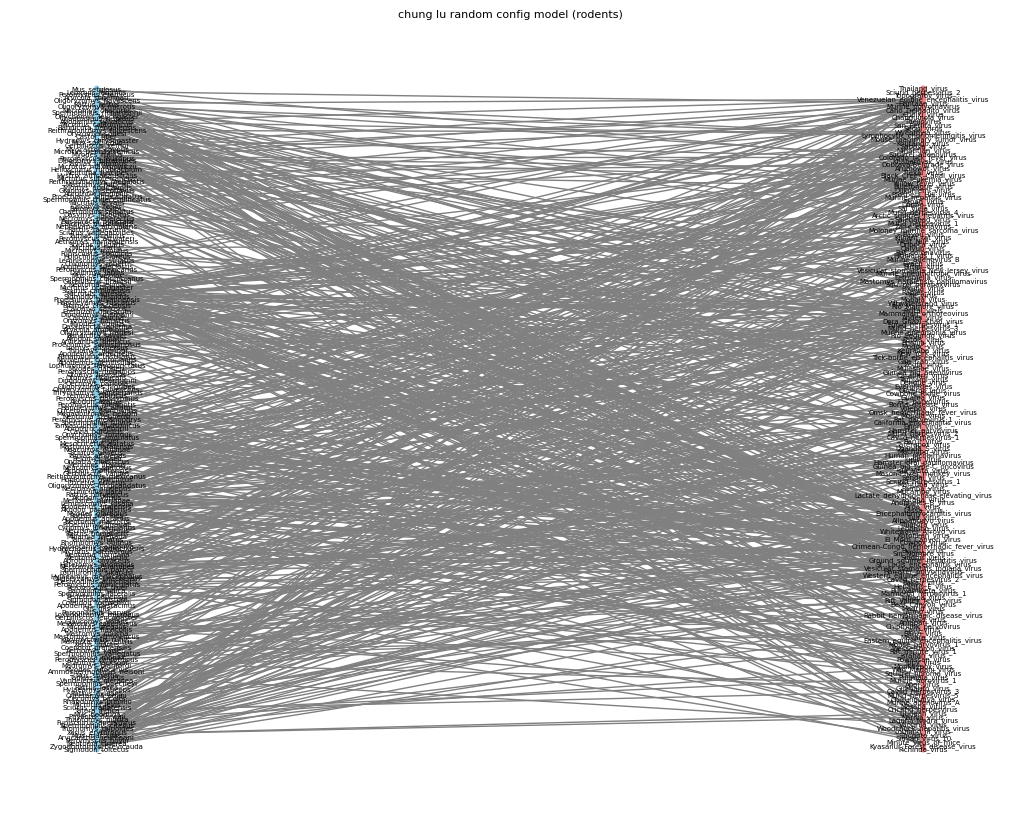

In [6]:
def chung_lu_bipartite_graph(G_rat, hosts, viruses, seed=0):
    rng = np.random.default_rng(seed)

    dU = np.fromiter((G_rat.degree(u) for u in hosts), dtype=float)
    dV = np.fromiter((G_rat.degree(v) for v in viruses), dtype=float)

    mU, mV = dU.sum(), dV.sum()
    if mU == 0 or mV == 0:
        H = nx.Graph()
        H.add_nodes_from(hosts, bipartite=0)
        H.add_nodes_from(viruses, bipartite=1)
        return H  

    m = (mU + mV) / 2.0
    p = np.outer(dU, dV) / m
    np.clip(p, 0.0, 1.0, out=p)

    A = rng.random(p.shape) < p
    ui, vj = np.nonzero(A)

    H = nx.Graph()
    H.add_nodes_from(hosts, bipartite=0)
    H.add_nodes_from(viruses, bipartite=1)
    H.add_edges_from((hosts[i], viruses[j]) for i, j in zip(ui, vj))
    return H


H_null = chung_lu_bipartite_graph(G_rat, hosts_rat, viruses_rat, seed=4)
pos = nx.bipartite_layout(H_null, hosts_rat)
plt.figure(figsize=(10, 8))
nx.draw(
    H_null,
    pos,
    with_labels=True,
    node_color=["skyblue" if n in hosts_rat else "lightcoral" for n in H_null.nodes()],
    node_size=10,
    edge_color="gray",
    font_size=5
)

plt.title("chung lu random config model (rodents)", fontsize=8, pad=1)
plt.show()



In [7]:
#need pearson coefficient for null model



In [8]:
print("avg rodent degree:", sum(rat_degrees.values())/len(rat_degrees.values()))

print("avg rodent virus degree:", sum(rvirus_degrees.values())/len(rvirus_degrees.values())) #within the category of rodents/primates

print("clustering coeff. rodents:", cc_r)

print(f"pearson corr for rodent–virus: {r_rat:}") 
#what is the relationship of pearson to assortativity?

avg rodent degree: 3.004524886877828
avg rodent virus degree: 3.628415300546448
clustering coeff. rodents: 0.141628664495114
pearson corr for rodent–virus: -0.19375801379912094
